# BBOX

In [ ]:
import jsonlines
import json
import requests
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from io import BytesIO

def draw_boxes(image, predictions):
    draw = ImageDraw.Draw(image)
    
    # Draw predicted bounding boxes
    for pred in predictions:
        bbox = pred['bounding_box']
        bbox = [int(coord) for coord in bbox]
        label = pred['object_name']
        is_hallucination = pred['is_hallucination']
        is_misclassification = pred['is_misclassification']
        color = "red" if is_hallucination else "blue"
        color = "yellow" if is_misclassification else color
        draw.rectangle(bbox, outline=color, width=2)
        draw.text((bbox[0], bbox[1]), f"{label} (P)", fill=color)
    
    # Draw ground truth bounding boxes
    for pred in predictions:
        bbox = pred['bbox_match_box']
        bbox = [int(coord) for coord in bbox]
        label = pred['bbox_match_object']
        draw.rectangle(bbox, outline="green", width=2)
        draw.text((bbox[0], bbox[1]), f"{label} (GT)", fill="green")
    
    return image

data = []
with jsonlines.open('pipeline_outputs/bbox_hallucinations_hth_0.5_mth_0.5.jsonl') as reader:
    for obj in reader:
        data.append(obj)

with open('data/bbox_pope_images/labels.json') as f:
    labels = json.load(f)

image_urls = {img['file_name']: img['coco_url'] for img in labels['images']}

images_data = {}
for obj in data:
    image_id = obj['question_id']
    if image_id not in images_data:
        images_data[image_id] = []
    # Only include predictions where both is_hallucination and is_misclassification are False
    if not obj['is_hallucination'] and not obj['is_misclassification']:
        images_data[image_id].append(obj)

for image_id, predictions in images_data.items():
    if not predictions:  # Skip images with no valid predictions
        continue

    image_url = image_urls.get(image_id)
    if not image_url:
        print(f"Image URL for {image_id} not found.")
        continue
    
    response = requests.get(image_url)
    if response.status_code != 200:
        print(f"Failed to download image {image_id}")
        continue
    
    image = Image.open(BytesIO(response.content))
    
    image_with_boxes = draw_boxes(image, predictions)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.title(image_id)
    plt.show()


# BACKGROUND

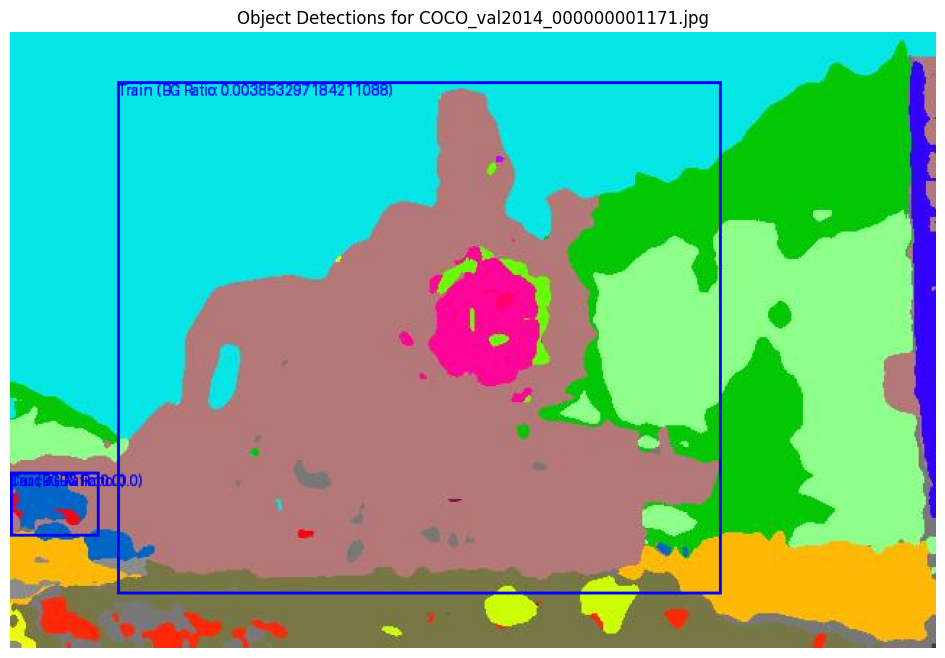

In [17]:
import jsonlines
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def scale_bbox(bbox, new_scale):
    corners = bbox.split(",")
    float_corners = [float(corner) / 1000 for corner in corners]
    scaled_x0, scaled_x1 = (int(float_corners[0] * new_scale[0]),
                            int(float_corners[2] * new_scale[0]))
    scaled_y0, scaled_y1 = (int(float_corners[1] * new_scale[1]),
                            int(float_corners[3] * new_scale[1]))
    return scaled_x0, scaled_y0, scaled_x1, scaled_y1

def draw_boxes(image, predictions, image_scale):
    draw = ImageDraw.Draw(image)
    
    for pred in predictions:
        bbox_str = pred['bounding_box']
        bbox = scale_bbox(bbox_str, image_scale)
        
        # Ensure the coordinates are in the correct order
        x0, y0, x1, y1 = bbox
        if x0 > x1:
            x0, x1 = x1, x0
        if y0 > y1:
            y0, y1 = y1, y0
        
        label = pred['object_name']
        background_ratio = pred['background_ratio']
        color = "blue"
        
        draw.rectangle([x0, y0, x1, y1], outline=color, width=2)
        draw.text((x0, y0), f"{label} (BG Ratio: {background_ratio:})", fill=color)
    
    return image

data = []
jsonl_file_path = 'pipeline_outputs/background_hallucinations_ade20k_0.75.jsonl' 
with jsonlines.open(jsonl_file_path) as reader:
    for obj in reader:
        data.append(obj)

image_path = 'segmentation_masks/COCO_val2014_000000001171.jpg' 
image = Image.open(image_path)
image_scale = image.size  

image_id = "COCO_val2014_000000001171.jpg" 

predictions = [pred for pred in data if pred['question_id'] == image_id]

image_with_boxes = draw_boxes(image, predictions, image_scale)

plt.figure(figsize=(12, 8))
plt.imshow(image_with_boxes)
plt.axis('off')
plt.title(f"Object Detections for {image_id}")
plt.show()
